In [23]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import timeit
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from sklearn.model_selection import train_test_split
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [26]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [27]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [28]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [29]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [30]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [31]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [32]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [33]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


In [34]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [35]:
print(data_path.Emotions.value_counts())


Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

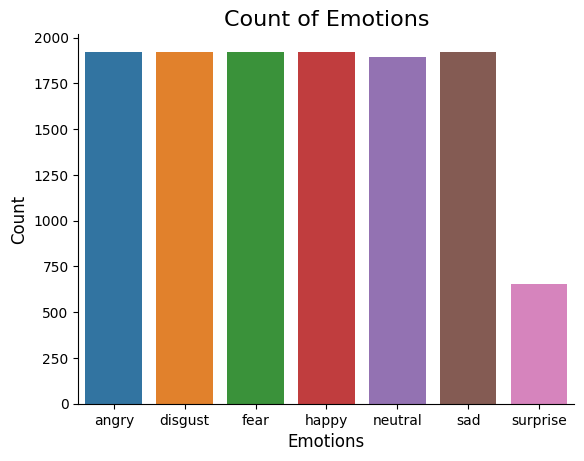

In [36]:
# Convert 'Emotions' column to categorical type
data_path['Emotions'] = data_path['Emotions'].astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [37]:
data,sr = librosa.load(file_path[0])
sr

22050

In [38]:
ipd.Audio(data,rate=sr)

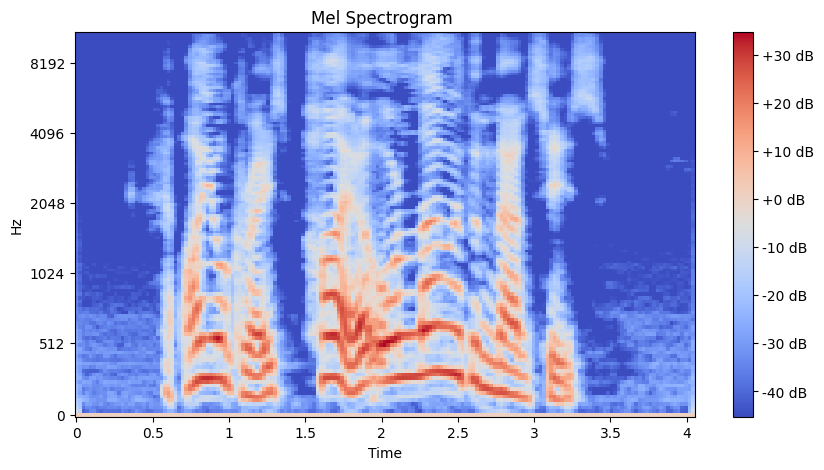

In [39]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

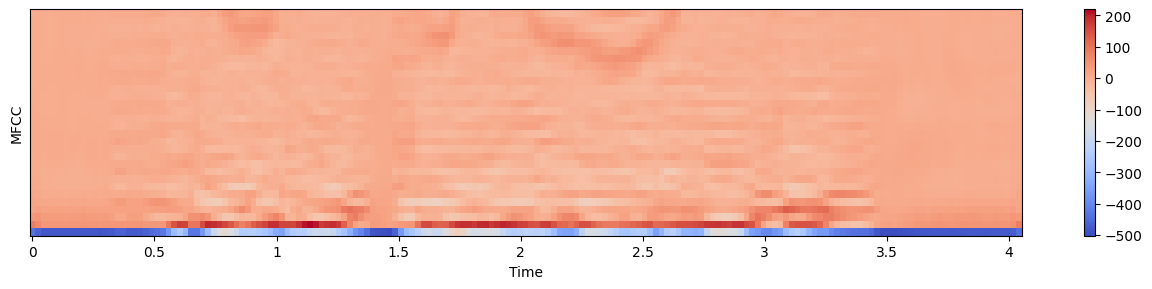

In [40]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [41]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

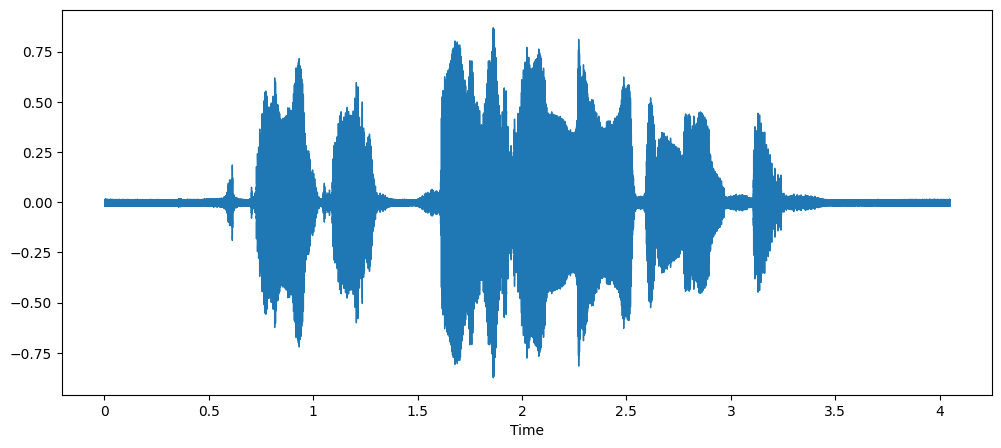

In [42]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

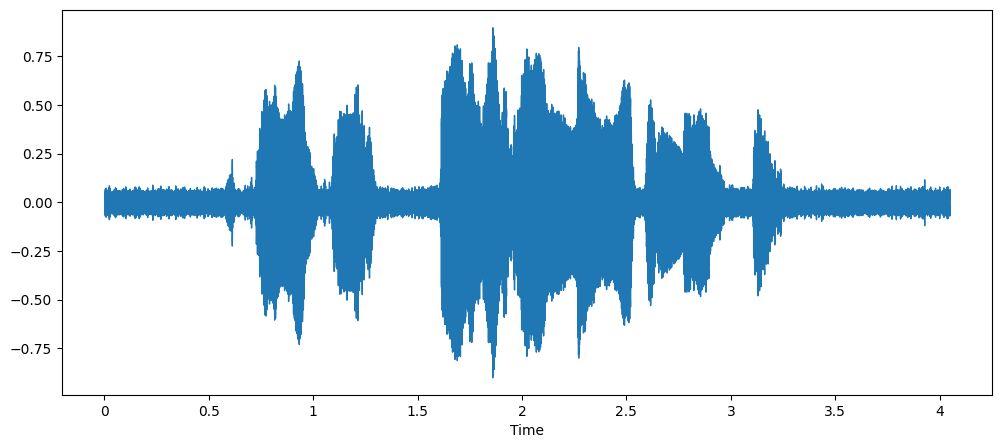

In [43]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

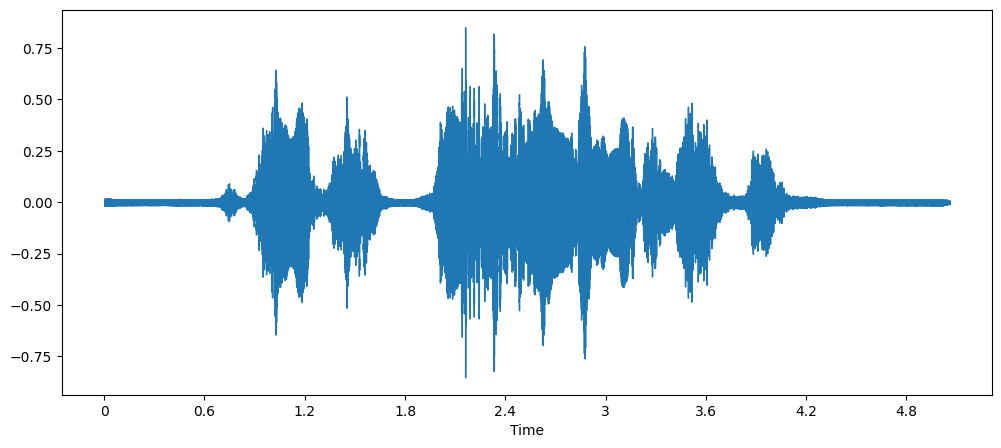

In [44]:

# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

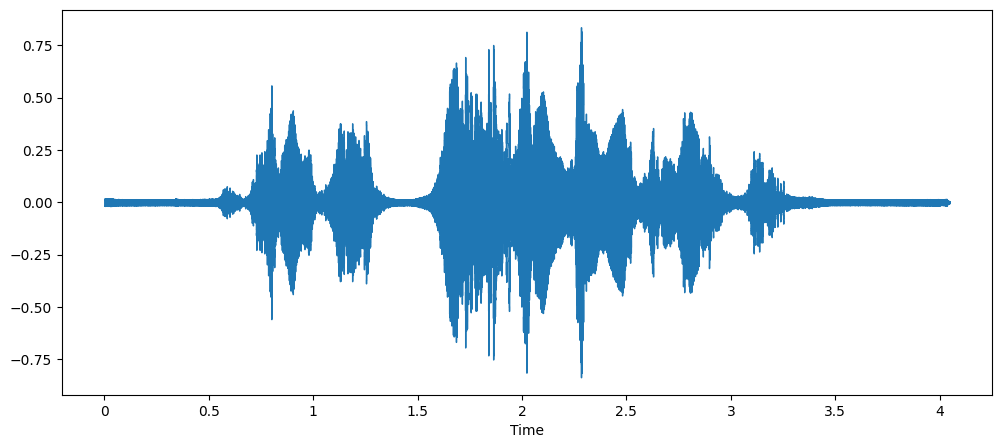

In [45]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [46]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y = data, S = None, frame_length = frame_length,hop_length = hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y = data, sr = sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result


def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


In [47]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


# Normal way to get features

In [48]:
'''import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)  '''       

"import timeit\nfrom tqdm import tqdm\nstart = timeit.default_timer()\nX,Y=[],[]\nfor path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):\n    features=get_features(path)\n    if index%500==0:\n        print(f'{index} audio has been processed')\n    for i in features:\n        X.append(i)\n        Y.append(emotion)\nprint('Done')\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)  "

# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that Normal**


This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [49]:
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

In [50]:
warnings.filterwarnings("ignore")

from joblib import Parallel, delayed
import timeit
from tqdm import tqdm

In [51]:
start = timeit.default_timer()
paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in tqdm(zip(paths, emotions)))

# Collect the results
X = []
Y = []
for result in tqdm(results):
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)   

12162it [10:05, 20.09it/s]
100%|██████████| 12162/12162 [00:00<00:00, 673120.95it/s]

Time:  605.8644365720002


In [52]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [53]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.248047,0.372070,0.492676,0.502441,0.486328,0.490723,0.489746,0.483398,0.488770,0.487793,...,4.641506,6.747554,4.294534,0.515794,-5.480772,-1.826192,5.482701,6.676369,2.147220,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838663,1.308733,1.855111,2.405192,2.896439,3.283493,3.541682,3.667480,surprise
3,0.255371,0.377441,0.489258,0.456055,0.407715,0.360352,0.317383,0.303223,0.309570,0.311523,...,-0.835939,-1.426970,3.003255,0.542349,-4.273534,-2.949996,-1.657338,-2.976427,-1.270806,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [54]:
Emotions = pd.read_csv('/kaggle/working/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.248047,0.372070,0.492676,0.502441,0.486328,0.490723,0.489746,0.483398,0.488770,0.487793,...,4.641506,6.747554,4.294534,0.515794,-5.480772,-1.826192,5.482701,6.676369,2.147220,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838663,1.308733,1.855111,2.405192,2.896439,3.283493,3.541682,3.667480,surprise
3,0.255371,0.377441,0.489258,0.456055,0.407715,0.360352,0.317383,0.303223,0.309570,0.311523,...,-0.835939,-1.426970,3.003255,0.542349,-4.273534,-2.949996,-1.657338,-2.976427,-1.270806,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [55]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [56]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [57]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [58]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
y = Emotions.iloc[:, -1].values

In [59]:
print(y.shape)
X.shape

(48648,)


(48648, 2376)

In [60]:
# Encode labels
# One-hot encode your labels
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


# Split your dataset into training and a temporary test set
X_train, X_temp, y_train, y_temp = train_test_split(X, Y_encoded, test_size=0.3, random_state=42)


# Split the temporary test set into actual test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [61]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [62]:
# Let's check the shape of X_train
print("Original shape:", X_train.shape)

Original shape: (34053, 2376)


In [63]:
# Let's check the shape of X_train
print("Original shape:", X_train.shape)

# Add a channel dimension to make it compatible with Conv2D
# Add a channel dimension to make it compatible with Conv2D
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("New shape:", X_train.shape)

Original shape: (34053, 2376)
New shape: (34053, 1, 2376)


 # MODEL BUILDING

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim

In [65]:
# Dataset
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [66]:
# Early stopping class implementation in PyTorch
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [67]:
# Initialize early stopper
early_stopper = EarlyStopping(patience=100, verbose=True, path='best_model_transformer.pth')


In [68]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        # Define the convolutional blocks using 1D convolutions
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  # Maintain dimension
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)  # Halves the sequence length
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Transformer encoder setup
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=8), num_layers=4
        )
        
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x should be of shape [batch_size, channels, sequence_length]
        # Ensure x is correctly shaped for 1D convolutions
        x = x.view(x.size(0), 1, -1)  # Reshape to [batch, channels, sequence_length]

        # Pass through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Prepare for transformer encoder
        # You might need to adjust dimensions depending on the output of the last conv layer
        x = x.permute(2, 0, 1)  # Transformer expects [seq_len, batch, features]

        # Transformer encoder
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=0)  # Average over sequence

        # Final fully connected layer
        x = self.fc(x)
        return x

In [69]:
# Assuming `y` is your labels array to determine the number of unique classes
num_classes = len(np.unique(Y))
#model = AudioClassifier(num_classes=num_classes)

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
# Check for GPU availability
if torch.cuda.is_available() and device == 'cuda':
    model = model.to(device)
else:
    device = 'cpu'  # Use CPU if CUDA isn't available

In [72]:
# Ensure the model is moved to the right device
model = AudioClassifier(num_classes=num_classes).to(device)  # Update `num_classes` as needed
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
'''def train(model, criterion, optimizer, train_loader, val_loader, early_stopper, epochs=50, device='cuda'):
    # Check for GPU availability
    if torch.cuda.is_available() and device == 'cuda':
        model = model.to(device)
    else:
        device = 'cpu'  # Use CPU if CUDA isn't available

    for epoch in tqdm(range(epochs), desc="Epochs Progress"):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False)):
            # Transfer data and target to the appropriate device
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)
        
        # Calculate training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()

        with torch.no_grad():
            for data, target in tval_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Print training and validation results
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            print("Early stopping")
            break
            
'''            

In [74]:
def train(model, criterion, optimizer, train_loader, val_loader, early_stopper, epochs=50, device='cuda'):
    # Check for GPU availability
    if torch.cuda.is_available() and device == 'cuda':
        model = model.to(device)
    else:
        device = 'cpu'  # Use CPU if CUDA isn't available

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            # Transfer data and target to the appropriate device
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)
        
        # Calculate training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Print training and validation results
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            print("Early stopping")
            break


In [75]:
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train, axis=1)
y_val_indices = np.argmax(y_val, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

In [76]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

In [77]:

# Create Datasets
train_dataset = AudioDataset(X_train_tensor, y_train_tensor)
val_dataset = AudioDataset(X_val_tensor, y_val_tensor)
test_dataset = AudioDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [78]:
# Assume model, criterion, optimizer are already defined
train(model, criterion, optimizer, train_loader, val_loader, early_stopper, epochs=500)

  0%|          | 1/500 [00:58<8:07:07, 58.57s/it]

Epoch 1/500 - Train Loss: 1.6792, Train Acc: 0.3118, Val Loss: 1.5841, Val Acc: 0.3530
Validation loss decreased (inf --> 1.584072).  Saving model ...


  0%|          | 2/500 [01:56<8:00:51, 57.93s/it]

Epoch 2/500 - Train Loss: 1.5225, Train Acc: 0.3844, Val Loss: 1.4457, Val Acc: 0.4287
Validation loss decreased (1.584072 --> 1.445735).  Saving model ...


  1%|          | 3/500 [02:53<7:58:05, 57.72s/it]

Epoch 3/500 - Train Loss: 1.4370, Train Acc: 0.4309, Val Loss: 1.3745, Val Acc: 0.4528
Validation loss decreased (1.445735 --> 1.374517).  Saving model ...


  1%|          | 4/500 [03:51<7:56:28, 57.64s/it]

Epoch 4/500 - Train Loss: 1.3806, Train Acc: 0.4584, Val Loss: 1.3968, Val Acc: 0.4555
EarlyStopping counter: 1 out of 100


  1%|          | 5/500 [04:48<7:55:07, 57.59s/it]

Epoch 5/500 - Train Loss: 1.3267, Train Acc: 0.4778, Val Loss: 1.2768, Val Acc: 0.4953
Validation loss decreased (1.374517 --> 1.276822).  Saving model ...


  1%|          | 6/500 [05:46<7:53:59, 57.57s/it]

Epoch 6/500 - Train Loss: 1.2724, Train Acc: 0.5015, Val Loss: 1.2708, Val Acc: 0.4949
Validation loss decreased (1.276822 --> 1.270758).  Saving model ...


  1%|▏         | 7/500 [06:43<7:52:54, 57.56s/it]

Epoch 7/500 - Train Loss: 1.2373, Train Acc: 0.5098, Val Loss: 1.2230, Val Acc: 0.5168
Validation loss decreased (1.270758 --> 1.222986).  Saving model ...


  2%|▏         | 8/500 [07:41<7:51:49, 57.54s/it]

Epoch 8/500 - Train Loss: 1.1992, Train Acc: 0.5227, Val Loss: 1.2430, Val Acc: 0.5154
EarlyStopping counter: 1 out of 100


  2%|▏         | 9/500 [08:38<7:50:50, 57.54s/it]

Epoch 9/500 - Train Loss: 1.1754, Train Acc: 0.5347, Val Loss: 1.1808, Val Acc: 0.5330
Validation loss decreased (1.222986 --> 1.180771).  Saving model ...


  2%|▏         | 10/500 [09:36<7:49:50, 57.53s/it]

Epoch 10/500 - Train Loss: 1.1607, Train Acc: 0.5391, Val Loss: 1.1618, Val Acc: 0.5387
Validation loss decreased (1.180771 --> 1.161778).  Saving model ...


  2%|▏         | 11/500 [10:33<7:48:51, 57.53s/it]

Epoch 11/500 - Train Loss: 1.1318, Train Acc: 0.5506, Val Loss: 1.1493, Val Acc: 0.5482
Validation loss decreased (1.161778 --> 1.149311).  Saving model ...


  2%|▏         | 12/500 [11:31<7:47:53, 57.53s/it]

Epoch 12/500 - Train Loss: 1.1078, Train Acc: 0.5621, Val Loss: 1.1168, Val Acc: 0.5650
Validation loss decreased (1.149311 --> 1.116778).  Saving model ...


  3%|▎         | 13/500 [12:28<7:46:58, 57.53s/it]

Epoch 13/500 - Train Loss: 1.0898, Train Acc: 0.5704, Val Loss: 1.1322, Val Acc: 0.5600
EarlyStopping counter: 1 out of 100


  3%|▎         | 14/500 [13:26<7:46:06, 57.54s/it]

Epoch 14/500 - Train Loss: 1.0759, Train Acc: 0.5747, Val Loss: 1.0934, Val Acc: 0.5808
Validation loss decreased (1.116778 --> 1.093406).  Saving model ...


  3%|▎         | 15/500 [14:24<7:45:30, 57.59s/it]

Epoch 15/500 - Train Loss: 1.0557, Train Acc: 0.5805, Val Loss: 1.0833, Val Acc: 0.5787
Validation loss decreased (1.093406 --> 1.083257).  Saving model ...


  3%|▎         | 16/500 [15:21<7:45:08, 57.66s/it]

Epoch 16/500 - Train Loss: 1.0397, Train Acc: 0.5899, Val Loss: 1.0660, Val Acc: 0.5860
Validation loss decreased (1.083257 --> 1.066050).  Saving model ...


  3%|▎         | 17/500 [16:19<7:44:17, 57.68s/it]

Epoch 17/500 - Train Loss: 1.0311, Train Acc: 0.5956, Val Loss: 1.0875, Val Acc: 0.5806
EarlyStopping counter: 1 out of 100


  4%|▎         | 18/500 [17:17<7:42:59, 57.63s/it]

Epoch 18/500 - Train Loss: 1.0198, Train Acc: 0.5987, Val Loss: 1.1021, Val Acc: 0.5654
EarlyStopping counter: 2 out of 100


  4%|▍         | 19/500 [18:14<7:41:52, 57.61s/it]

Epoch 19/500 - Train Loss: 1.0059, Train Acc: 0.6046, Val Loss: 1.0817, Val Acc: 0.5759
EarlyStopping counter: 3 out of 100


  4%|▍         | 20/500 [19:12<7:40:44, 57.59s/it]

Epoch 20/500 - Train Loss: 0.9922, Train Acc: 0.6074, Val Loss: 1.0149, Val Acc: 0.6118
Validation loss decreased (1.066050 --> 1.014851).  Saving model ...


  4%|▍         | 21/500 [20:09<7:39:41, 57.58s/it]

Epoch 21/500 - Train Loss: 0.9861, Train Acc: 0.6151, Val Loss: 1.0197, Val Acc: 0.6026
EarlyStopping counter: 1 out of 100


  4%|▍         | 22/500 [21:07<7:38:50, 57.59s/it]

Epoch 22/500 - Train Loss: 0.9690, Train Acc: 0.6192, Val Loss: 1.0494, Val Acc: 0.5883
EarlyStopping counter: 2 out of 100


  5%|▍         | 23/500 [22:05<7:37:59, 57.61s/it]

Epoch 23/500 - Train Loss: 0.9695, Train Acc: 0.6168, Val Loss: 1.0929, Val Acc: 0.5824
EarlyStopping counter: 3 out of 100


  5%|▍         | 24/500 [23:02<7:37:19, 57.65s/it]

Epoch 24/500 - Train Loss: 0.9494, Train Acc: 0.6270, Val Loss: 1.0272, Val Acc: 0.6089
EarlyStopping counter: 4 out of 100


  5%|▌         | 25/500 [24:00<7:36:23, 57.65s/it]

Epoch 25/500 - Train Loss: 0.9458, Train Acc: 0.6314, Val Loss: 1.0822, Val Acc: 0.5727
EarlyStopping counter: 5 out of 100


  5%|▌         | 26/500 [24:58<7:35:19, 57.64s/it]

Epoch 26/500 - Train Loss: 0.9292, Train Acc: 0.6372, Val Loss: 0.9941, Val Acc: 0.6177
Validation loss decreased (1.014851 --> 0.994081).  Saving model ...


  5%|▌         | 27/500 [25:55<7:34:16, 57.63s/it]

Epoch 27/500 - Train Loss: 0.9247, Train Acc: 0.6381, Val Loss: 1.0533, Val Acc: 0.5992
EarlyStopping counter: 1 out of 100


  6%|▌         | 28/500 [26:53<7:33:16, 57.62s/it]

Epoch 28/500 - Train Loss: 0.9060, Train Acc: 0.6466, Val Loss: 0.9912, Val Acc: 0.6264
Validation loss decreased (0.994081 --> 0.991210).  Saving model ...


  6%|▌         | 29/500 [27:51<7:33:25, 57.76s/it]

Epoch 29/500 - Train Loss: 0.9010, Train Acc: 0.6481, Val Loss: 1.0534, Val Acc: 0.6096
EarlyStopping counter: 1 out of 100


  6%|▌         | 30/500 [28:49<7:33:40, 57.92s/it]

Epoch 30/500 - Train Loss: 0.8866, Train Acc: 0.6557, Val Loss: 0.9887, Val Acc: 0.6293
Validation loss decreased (0.991210 --> 0.988730).  Saving model ...


  6%|▌         | 31/500 [29:48<7:34:19, 58.12s/it]

Epoch 31/500 - Train Loss: 0.8864, Train Acc: 0.6567, Val Loss: 1.0263, Val Acc: 0.6068
EarlyStopping counter: 1 out of 100


  6%|▋         | 32/500 [30:46<7:33:35, 58.15s/it]

Epoch 32/500 - Train Loss: 0.8661, Train Acc: 0.6636, Val Loss: 0.9732, Val Acc: 0.6322
Validation loss decreased (0.988730 --> 0.973182).  Saving model ...


  7%|▋         | 33/500 [31:44<7:33:07, 58.22s/it]

Epoch 33/500 - Train Loss: 0.8585, Train Acc: 0.6658, Val Loss: 0.9920, Val Acc: 0.6260
EarlyStopping counter: 1 out of 100


  7%|▋         | 34/500 [32:42<7:32:09, 58.22s/it]

Epoch 34/500 - Train Loss: 0.8503, Train Acc: 0.6724, Val Loss: 1.0126, Val Acc: 0.6097
EarlyStopping counter: 2 out of 100


  7%|▋         | 35/500 [33:40<7:29:44, 58.03s/it]

Epoch 35/500 - Train Loss: 0.8411, Train Acc: 0.6732, Val Loss: 0.9665, Val Acc: 0.6344
Validation loss decreased (0.973182 --> 0.966477).  Saving model ...


  7%|▋         | 36/500 [34:38<7:27:43, 57.90s/it]

Epoch 36/500 - Train Loss: 0.8343, Train Acc: 0.6800, Val Loss: 1.0067, Val Acc: 0.6274
EarlyStopping counter: 1 out of 100


  7%|▋         | 37/500 [35:35<7:26:07, 57.81s/it]

Epoch 37/500 - Train Loss: 0.8205, Train Acc: 0.6821, Val Loss: 0.9713, Val Acc: 0.6271
EarlyStopping counter: 2 out of 100


  8%|▊         | 38/500 [36:34<7:26:32, 57.99s/it]

Epoch 38/500 - Train Loss: 0.8119, Train Acc: 0.6853, Val Loss: 0.9548, Val Acc: 0.6426
Validation loss decreased (0.966477 --> 0.954831).  Saving model ...


  8%|▊         | 39/500 [37:32<7:26:12, 58.07s/it]

Epoch 39/500 - Train Loss: 0.8024, Train Acc: 0.6927, Val Loss: 0.9779, Val Acc: 0.6414
EarlyStopping counter: 1 out of 100


  8%|▊         | 40/500 [38:30<7:26:01, 58.18s/it]

Epoch 40/500 - Train Loss: 0.7860, Train Acc: 0.6999, Val Loss: 1.0454, Val Acc: 0.6223
EarlyStopping counter: 2 out of 100


  8%|▊         | 41/500 [39:29<7:25:02, 58.18s/it]

Epoch 41/500 - Train Loss: 0.7804, Train Acc: 0.7023, Val Loss: 1.0179, Val Acc: 0.6274
EarlyStopping counter: 3 out of 100


  8%|▊         | 42/500 [40:27<7:23:51, 58.15s/it]

Epoch 42/500 - Train Loss: 0.7716, Train Acc: 0.7044, Val Loss: 0.9844, Val Acc: 0.6334
EarlyStopping counter: 4 out of 100


  9%|▊         | 43/500 [41:25<7:23:06, 58.18s/it]

Epoch 43/500 - Train Loss: 0.7623, Train Acc: 0.7071, Val Loss: 1.0258, Val Acc: 0.6231
EarlyStopping counter: 5 out of 100


  9%|▉         | 44/500 [42:23<7:22:22, 58.21s/it]

Epoch 44/500 - Train Loss: 0.7520, Train Acc: 0.7118, Val Loss: 1.0080, Val Acc: 0.6371
EarlyStopping counter: 6 out of 100


  9%|▉         | 45/500 [43:21<7:21:35, 58.23s/it]

Epoch 45/500 - Train Loss: 0.7449, Train Acc: 0.7125, Val Loss: 0.9725, Val Acc: 0.6551
EarlyStopping counter: 7 out of 100


  9%|▉         | 46/500 [44:20<7:20:43, 58.25s/it]

Epoch 46/500 - Train Loss: 0.7296, Train Acc: 0.7192, Val Loss: 0.9549, Val Acc: 0.6651
EarlyStopping counter: 8 out of 100


  9%|▉         | 47/500 [45:18<7:19:52, 58.26s/it]

Epoch 47/500 - Train Loss: 0.7220, Train Acc: 0.7237, Val Loss: 0.9792, Val Acc: 0.6448
EarlyStopping counter: 9 out of 100


 10%|▉         | 48/500 [46:16<7:19:20, 58.32s/it]

Epoch 48/500 - Train Loss: 0.7127, Train Acc: 0.7264, Val Loss: 0.9566, Val Acc: 0.6551
EarlyStopping counter: 10 out of 100


 10%|▉         | 49/500 [47:15<7:18:40, 58.36s/it]

Epoch 49/500 - Train Loss: 0.6984, Train Acc: 0.7329, Val Loss: 0.9697, Val Acc: 0.6553
EarlyStopping counter: 11 out of 100


 10%|█         | 50/500 [48:13<7:16:11, 58.16s/it]

Epoch 50/500 - Train Loss: 0.6931, Train Acc: 0.7367, Val Loss: 1.0019, Val Acc: 0.6508
EarlyStopping counter: 12 out of 100


 10%|█         | 51/500 [49:10<7:13:55, 57.99s/it]

Epoch 51/500 - Train Loss: 0.6801, Train Acc: 0.7404, Val Loss: 0.9494, Val Acc: 0.6505
Validation loss decreased (0.954831 --> 0.949410).  Saving model ...


 10%|█         | 52/500 [50:08<7:12:05, 57.87s/it]

Epoch 52/500 - Train Loss: 0.6693, Train Acc: 0.7477, Val Loss: 0.9938, Val Acc: 0.6414
EarlyStopping counter: 1 out of 100


 11%|█         | 53/500 [51:05<7:10:35, 57.80s/it]

Epoch 53/500 - Train Loss: 0.6644, Train Acc: 0.7487, Val Loss: 0.9430, Val Acc: 0.6585
Validation loss decreased (0.949410 --> 0.942965).  Saving model ...


 11%|█         | 54/500 [52:03<7:09:15, 57.75s/it]

Epoch 54/500 - Train Loss: 0.6544, Train Acc: 0.7539, Val Loss: 0.9427, Val Acc: 0.6537
Validation loss decreased (0.942965 --> 0.942678).  Saving model ...


 11%|█         | 55/500 [53:01<7:08:18, 57.75s/it]

Epoch 55/500 - Train Loss: 0.6336, Train Acc: 0.7608, Val Loss: 1.0155, Val Acc: 0.6571
EarlyStopping counter: 1 out of 100


 11%|█         | 56/500 [53:59<7:07:20, 57.75s/it]

Epoch 56/500 - Train Loss: 0.6269, Train Acc: 0.7630, Val Loss: 0.9851, Val Acc: 0.6631
EarlyStopping counter: 2 out of 100


 11%|█▏        | 57/500 [54:56<7:05:55, 57.69s/it]

Epoch 57/500 - Train Loss: 0.6171, Train Acc: 0.7676, Val Loss: 1.0546, Val Acc: 0.6462
EarlyStopping counter: 3 out of 100


 12%|█▏        | 58/500 [55:54<7:05:06, 57.71s/it]

Epoch 58/500 - Train Loss: 0.6128, Train Acc: 0.7690, Val Loss: 0.9607, Val Acc: 0.6647
EarlyStopping counter: 4 out of 100


 12%|█▏        | 59/500 [56:52<7:04:34, 57.76s/it]

Epoch 59/500 - Train Loss: 0.5957, Train Acc: 0.7775, Val Loss: 0.9917, Val Acc: 0.6715
EarlyStopping counter: 5 out of 100


 12%|█▏        | 60/500 [57:50<7:03:41, 57.78s/it]

Epoch 60/500 - Train Loss: 0.5896, Train Acc: 0.7788, Val Loss: 0.9675, Val Acc: 0.6670
EarlyStopping counter: 6 out of 100


 12%|█▏        | 61/500 [58:47<7:02:35, 57.76s/it]

Epoch 61/500 - Train Loss: 0.5791, Train Acc: 0.7842, Val Loss: 0.9531, Val Acc: 0.6771
EarlyStopping counter: 7 out of 100


 12%|█▏        | 62/500 [59:45<7:01:28, 57.74s/it]

Epoch 62/500 - Train Loss: 0.5688, Train Acc: 0.7860, Val Loss: 0.9715, Val Acc: 0.6730
EarlyStopping counter: 8 out of 100


 13%|█▎        | 63/500 [1:00:43<7:00:24, 57.72s/it]

Epoch 63/500 - Train Loss: 0.5603, Train Acc: 0.7918, Val Loss: 0.9752, Val Acc: 0.6755
EarlyStopping counter: 9 out of 100


 13%|█▎        | 64/500 [1:01:40<6:59:23, 57.72s/it]

Epoch 64/500 - Train Loss: 0.5503, Train Acc: 0.7934, Val Loss: 0.9192, Val Acc: 0.6801
Validation loss decreased (0.942678 --> 0.919202).  Saving model ...


 13%|█▎        | 65/500 [1:02:38<6:58:36, 57.74s/it]

Epoch 65/500 - Train Loss: 0.5361, Train Acc: 0.8007, Val Loss: 0.9527, Val Acc: 0.6737
EarlyStopping counter: 1 out of 100


 13%|█▎        | 66/500 [1:03:36<6:58:45, 57.89s/it]

Epoch 66/500 - Train Loss: 0.5248, Train Acc: 0.8040, Val Loss: 0.9637, Val Acc: 0.6838
EarlyStopping counter: 2 out of 100


 13%|█▎        | 67/500 [1:04:35<6:58:36, 58.01s/it]

Epoch 67/500 - Train Loss: 0.5141, Train Acc: 0.8084, Val Loss: 1.0752, Val Acc: 0.6663
EarlyStopping counter: 3 out of 100


 14%|█▎        | 68/500 [1:05:33<6:58:13, 58.09s/it]

Epoch 68/500 - Train Loss: 0.5034, Train Acc: 0.8121, Val Loss: 1.0495, Val Acc: 0.6626
EarlyStopping counter: 4 out of 100


 14%|█▍        | 69/500 [1:06:31<6:57:48, 58.16s/it]

Epoch 69/500 - Train Loss: 0.4941, Train Acc: 0.8146, Val Loss: 0.9840, Val Acc: 0.6749
EarlyStopping counter: 5 out of 100


 14%|█▍        | 70/500 [1:07:30<6:57:14, 58.22s/it]

Epoch 70/500 - Train Loss: 0.4828, Train Acc: 0.8207, Val Loss: 1.0395, Val Acc: 0.6714
EarlyStopping counter: 6 out of 100


 14%|█▍        | 71/500 [1:08:28<6:55:51, 58.16s/it]

Epoch 71/500 - Train Loss: 0.4737, Train Acc: 0.8231, Val Loss: 1.0014, Val Acc: 0.6795
EarlyStopping counter: 7 out of 100


 15%|█▍        | 74/500 [1:11:21<6:51:09, 57.91s/it]

Epoch 74/500 - Train Loss: 0.4443, Train Acc: 0.8353, Val Loss: 0.9916, Val Acc: 0.6888
EarlyStopping counter: 10 out of 100


 15%|█▌        | 75/500 [1:12:19<6:49:49, 57.86s/it]

Epoch 75/500 - Train Loss: 0.4384, Train Acc: 0.8365, Val Loss: 0.9916, Val Acc: 0.6948
EarlyStopping counter: 11 out of 100


 15%|█▌        | 76/500 [1:13:17<6:48:52, 57.86s/it]

Epoch 76/500 - Train Loss: 0.4268, Train Acc: 0.8421, Val Loss: 1.0795, Val Acc: 0.6858
EarlyStopping counter: 12 out of 100


 15%|█▌        | 77/500 [1:14:15<6:48:24, 57.93s/it]

Epoch 77/500 - Train Loss: 0.4272, Train Acc: 0.8407, Val Loss: 1.0570, Val Acc: 0.6874
EarlyStopping counter: 13 out of 100


 16%|█▌        | 78/500 [1:15:13<6:47:52, 57.99s/it]

Epoch 78/500 - Train Loss: 0.4054, Train Acc: 0.8512, Val Loss: 1.0700, Val Acc: 0.6832
EarlyStopping counter: 14 out of 100


 16%|█▌        | 79/500 [1:16:11<6:47:15, 58.04s/it]

Epoch 79/500 - Train Loss: 0.3978, Train Acc: 0.8530, Val Loss: 1.0245, Val Acc: 0.6977
EarlyStopping counter: 15 out of 100


 16%|█▌        | 80/500 [1:17:09<6:46:31, 58.07s/it]

Epoch 80/500 - Train Loss: 0.3890, Train Acc: 0.8553, Val Loss: 1.0516, Val Acc: 0.6937
EarlyStopping counter: 16 out of 100


 16%|█▌        | 81/500 [1:18:07<6:45:38, 58.09s/it]

Epoch 81/500 - Train Loss: 0.3777, Train Acc: 0.8582, Val Loss: 1.0269, Val Acc: 0.7003
EarlyStopping counter: 17 out of 100


 16%|█▋        | 82/500 [1:19:05<6:44:29, 58.06s/it]

Epoch 82/500 - Train Loss: 0.3738, Train Acc: 0.8616, Val Loss: 1.0132, Val Acc: 0.7043
EarlyStopping counter: 18 out of 100


 17%|█▋        | 83/500 [1:20:03<6:43:20, 58.04s/it]

Epoch 83/500 - Train Loss: 0.3601, Train Acc: 0.8669, Val Loss: 1.0740, Val Acc: 0.6930
EarlyStopping counter: 19 out of 100


 17%|█▋        | 84/500 [1:21:01<6:42:22, 58.04s/it]

Epoch 84/500 - Train Loss: 0.3503, Train Acc: 0.8721, Val Loss: 1.0703, Val Acc: 0.6975
EarlyStopping counter: 20 out of 100


 17%|█▋        | 85/500 [1:22:00<6:41:58, 58.12s/it]

Epoch 85/500 - Train Loss: 0.3478, Train Acc: 0.8710, Val Loss: 1.1548, Val Acc: 0.6792
EarlyStopping counter: 21 out of 100


 17%|█▋        | 86/500 [1:22:58<6:41:22, 58.17s/it]

Epoch 86/500 - Train Loss: 0.3365, Train Acc: 0.8763, Val Loss: 0.9997, Val Acc: 0.7080
EarlyStopping counter: 22 out of 100


 17%|█▋        | 87/500 [1:23:56<6:41:03, 58.27s/it]

Epoch 87/500 - Train Loss: 0.3292, Train Acc: 0.8790, Val Loss: 1.1496, Val Acc: 0.6919
EarlyStopping counter: 23 out of 100


 18%|█▊        | 88/500 [1:24:55<6:40:19, 58.30s/it]

Epoch 88/500 - Train Loss: 0.3205, Train Acc: 0.8834, Val Loss: 1.0459, Val Acc: 0.7065
EarlyStopping counter: 24 out of 100


 18%|█▊        | 89/500 [1:25:53<6:39:26, 58.31s/it]

Epoch 89/500 - Train Loss: 0.3115, Train Acc: 0.8864, Val Loss: 1.1283, Val Acc: 0.6938
EarlyStopping counter: 25 out of 100


 18%|█▊        | 90/500 [1:26:52<6:38:45, 58.36s/it]

Epoch 90/500 - Train Loss: 0.3064, Train Acc: 0.8881, Val Loss: 1.0852, Val Acc: 0.7088
EarlyStopping counter: 26 out of 100


 18%|█▊        | 91/500 [1:27:50<6:38:08, 58.41s/it]

Epoch 91/500 - Train Loss: 0.2971, Train Acc: 0.8919, Val Loss: 1.0533, Val Acc: 0.7081
EarlyStopping counter: 27 out of 100


 18%|█▊        | 92/500 [1:28:49<6:37:16, 58.42s/it]

Epoch 92/500 - Train Loss: 0.2891, Train Acc: 0.8932, Val Loss: 1.0805, Val Acc: 0.7169
EarlyStopping counter: 28 out of 100


 19%|█▊        | 93/500 [1:29:47<6:36:06, 58.39s/it]

Epoch 93/500 - Train Loss: 0.2829, Train Acc: 0.8948, Val Loss: 1.1206, Val Acc: 0.7041
EarlyStopping counter: 29 out of 100


 19%|█▉        | 94/500 [1:30:45<6:35:20, 58.42s/it]

Epoch 94/500 - Train Loss: 0.2757, Train Acc: 0.8989, Val Loss: 1.1031, Val Acc: 0.7167
EarlyStopping counter: 30 out of 100


 19%|█▉        | 95/500 [1:31:44<6:34:20, 58.42s/it]

Epoch 95/500 - Train Loss: 0.2695, Train Acc: 0.9026, Val Loss: 1.1353, Val Acc: 0.7023
EarlyStopping counter: 31 out of 100


 19%|█▉        | 96/500 [1:32:42<6:33:25, 58.43s/it]

Epoch 96/500 - Train Loss: 0.2650, Train Acc: 0.9040, Val Loss: 1.0697, Val Acc: 0.7211
EarlyStopping counter: 32 out of 100


 19%|█▉        | 97/500 [1:33:41<6:32:30, 58.44s/it]

Epoch 97/500 - Train Loss: 0.2600, Train Acc: 0.9044, Val Loss: 1.1598, Val Acc: 0.7092
EarlyStopping counter: 33 out of 100


 20%|█▉        | 98/500 [1:34:39<6:31:32, 58.44s/it]

Epoch 98/500 - Train Loss: 0.2547, Train Acc: 0.9087, Val Loss: 1.0628, Val Acc: 0.7230
EarlyStopping counter: 34 out of 100


 20%|█▉        | 99/500 [1:35:38<6:30:23, 58.41s/it]

Epoch 99/500 - Train Loss: 0.2474, Train Acc: 0.9113, Val Loss: 1.0921, Val Acc: 0.7203
EarlyStopping counter: 35 out of 100


 20%|██        | 100/500 [1:36:36<6:29:23, 58.41s/it]

Epoch 100/500 - Train Loss: 0.2395, Train Acc: 0.9126, Val Loss: 1.1842, Val Acc: 0.7100
EarlyStopping counter: 36 out of 100


 20%|██        | 101/500 [1:37:34<6:28:15, 58.39s/it]

Epoch 101/500 - Train Loss: 0.2308, Train Acc: 0.9147, Val Loss: 1.0784, Val Acc: 0.7255
EarlyStopping counter: 37 out of 100


 20%|██        | 102/500 [1:38:33<6:27:10, 58.37s/it]

Epoch 102/500 - Train Loss: 0.2322, Train Acc: 0.9160, Val Loss: 1.1122, Val Acc: 0.7092
EarlyStopping counter: 38 out of 100


 21%|██        | 103/500 [1:39:31<6:26:03, 58.35s/it]

Epoch 103/500 - Train Loss: 0.2212, Train Acc: 0.9214, Val Loss: 1.0730, Val Acc: 0.7277
EarlyStopping counter: 39 out of 100


 21%|██        | 104/500 [1:40:29<6:25:03, 58.34s/it]

Epoch 104/500 - Train Loss: 0.2214, Train Acc: 0.9208, Val Loss: 1.2350, Val Acc: 0.7080
EarlyStopping counter: 40 out of 100


 21%|██        | 105/500 [1:41:28<6:24:04, 58.34s/it]

Epoch 105/500 - Train Loss: 0.2170, Train Acc: 0.9211, Val Loss: 1.2332, Val Acc: 0.7123
EarlyStopping counter: 41 out of 100


 21%|██        | 106/500 [1:42:26<6:23:02, 58.33s/it]

Epoch 106/500 - Train Loss: 0.2086, Train Acc: 0.9247, Val Loss: 1.0810, Val Acc: 0.7329
EarlyStopping counter: 42 out of 100


 21%|██▏       | 107/500 [1:43:24<6:22:01, 58.32s/it]

Epoch 107/500 - Train Loss: 0.2049, Train Acc: 0.9267, Val Loss: 1.0808, Val Acc: 0.7296
EarlyStopping counter: 43 out of 100


 22%|██▏       | 108/500 [1:44:23<6:21:11, 58.35s/it]

Epoch 108/500 - Train Loss: 0.2108, Train Acc: 0.9253, Val Loss: 1.1043, Val Acc: 0.7302
EarlyStopping counter: 44 out of 100


 22%|██▏       | 109/500 [1:45:21<6:20:04, 58.32s/it]

Epoch 109/500 - Train Loss: 0.1955, Train Acc: 0.9289, Val Loss: 1.1473, Val Acc: 0.7126
EarlyStopping counter: 45 out of 100


 22%|██▏       | 110/500 [1:46:19<6:19:02, 58.31s/it]

Epoch 110/500 - Train Loss: 0.1948, Train Acc: 0.9279, Val Loss: 1.1337, Val Acc: 0.7195
EarlyStopping counter: 46 out of 100


 22%|██▏       | 111/500 [1:47:18<6:18:10, 58.33s/it]

Epoch 111/500 - Train Loss: 0.1889, Train Acc: 0.9319, Val Loss: 1.0986, Val Acc: 0.7306
EarlyStopping counter: 47 out of 100


 22%|██▏       | 112/500 [1:48:16<6:17:21, 58.36s/it]

Epoch 112/500 - Train Loss: 0.1902, Train Acc: 0.9303, Val Loss: 1.0678, Val Acc: 0.7432
EarlyStopping counter: 48 out of 100


 23%|██▎       | 113/500 [1:49:14<6:16:23, 58.36s/it]

Epoch 113/500 - Train Loss: 0.1786, Train Acc: 0.9370, Val Loss: 1.1268, Val Acc: 0.7313
EarlyStopping counter: 49 out of 100


 23%|██▎       | 114/500 [1:50:13<6:15:20, 58.34s/it]

Epoch 114/500 - Train Loss: 0.1834, Train Acc: 0.9317, Val Loss: 1.1261, Val Acc: 0.7303
EarlyStopping counter: 50 out of 100


 23%|██▎       | 115/500 [1:51:11<6:14:15, 58.33s/it]

Epoch 115/500 - Train Loss: 0.1707, Train Acc: 0.9378, Val Loss: 1.1623, Val Acc: 0.7296
EarlyStopping counter: 51 out of 100


 23%|██▎       | 116/500 [1:52:09<6:13:11, 58.31s/it]

Epoch 116/500 - Train Loss: 0.1743, Train Acc: 0.9380, Val Loss: 1.2375, Val Acc: 0.7355
EarlyStopping counter: 52 out of 100


 23%|██▎       | 117/500 [1:53:07<6:12:11, 58.31s/it]

Epoch 117/500 - Train Loss: 0.1698, Train Acc: 0.9409, Val Loss: 1.1430, Val Acc: 0.7271
EarlyStopping counter: 53 out of 100


 24%|██▎       | 118/500 [1:54:06<6:11:16, 58.31s/it]

Epoch 118/500 - Train Loss: 0.1676, Train Acc: 0.9394, Val Loss: 1.1816, Val Acc: 0.7347
EarlyStopping counter: 54 out of 100


 24%|██▍       | 119/500 [1:55:04<6:10:08, 58.29s/it]

Epoch 119/500 - Train Loss: 0.1619, Train Acc: 0.9409, Val Loss: 1.2671, Val Acc: 0.7303
EarlyStopping counter: 55 out of 100


 24%|██▍       | 120/500 [1:56:02<6:08:56, 58.26s/it]

Epoch 120/500 - Train Loss: 0.1624, Train Acc: 0.9420, Val Loss: 1.2022, Val Acc: 0.7319
EarlyStopping counter: 56 out of 100


 24%|██▍       | 121/500 [1:57:01<6:08:03, 58.27s/it]

Epoch 121/500 - Train Loss: 0.1581, Train Acc: 0.9425, Val Loss: 1.2075, Val Acc: 0.7352
EarlyStopping counter: 57 out of 100


 24%|██▍       | 122/500 [1:57:59<6:07:16, 58.30s/it]

Epoch 122/500 - Train Loss: 0.1570, Train Acc: 0.9444, Val Loss: 1.1922, Val Acc: 0.7333
EarlyStopping counter: 58 out of 100


 25%|██▍       | 123/500 [1:58:57<6:06:15, 58.29s/it]

Epoch 123/500 - Train Loss: 0.1521, Train Acc: 0.9455, Val Loss: 1.1038, Val Acc: 0.7411
EarlyStopping counter: 59 out of 100


 25%|██▍       | 124/500 [1:59:55<6:05:23, 58.31s/it]

Epoch 124/500 - Train Loss: 0.1517, Train Acc: 0.9441, Val Loss: 1.2147, Val Acc: 0.7304
EarlyStopping counter: 60 out of 100


 25%|██▌       | 125/500 [2:00:54<6:04:29, 58.32s/it]

Epoch 125/500 - Train Loss: 0.1486, Train Acc: 0.9457, Val Loss: 1.1993, Val Acc: 0.7443
EarlyStopping counter: 61 out of 100


 25%|██▌       | 126/500 [2:01:52<6:03:33, 58.33s/it]

Epoch 126/500 - Train Loss: 0.1524, Train Acc: 0.9451, Val Loss: 1.1670, Val Acc: 0.7399
EarlyStopping counter: 62 out of 100


 25%|██▌       | 127/500 [2:02:50<6:02:32, 58.32s/it]

Epoch 127/500 - Train Loss: 0.1468, Train Acc: 0.9476, Val Loss: 1.2222, Val Acc: 0.7340
EarlyStopping counter: 63 out of 100


 26%|██▌       | 128/500 [2:03:49<6:01:43, 58.34s/it]

Epoch 128/500 - Train Loss: 0.1424, Train Acc: 0.9485, Val Loss: 1.1459, Val Acc: 0.7367
EarlyStopping counter: 64 out of 100


 26%|██▌       | 129/500 [2:04:47<6:00:54, 58.37s/it]

Epoch 129/500 - Train Loss: 0.1385, Train Acc: 0.9514, Val Loss: 1.1931, Val Acc: 0.7348
EarlyStopping counter: 65 out of 100


 26%|██▌       | 130/500 [2:05:46<6:00:02, 58.38s/it]

Epoch 130/500 - Train Loss: 0.1388, Train Acc: 0.9495, Val Loss: 1.1883, Val Acc: 0.7451
EarlyStopping counter: 66 out of 100


 26%|██▌       | 131/500 [2:06:44<5:58:51, 58.35s/it]

Epoch 131/500 - Train Loss: 0.1408, Train Acc: 0.9498, Val Loss: 1.2425, Val Acc: 0.7359
EarlyStopping counter: 67 out of 100


 26%|██▋       | 132/500 [2:07:42<5:57:16, 58.25s/it]

Epoch 132/500 - Train Loss: 0.1326, Train Acc: 0.9525, Val Loss: 1.2574, Val Acc: 0.7443
EarlyStopping counter: 68 out of 100


 27%|██▋       | 133/500 [2:08:40<5:55:35, 58.13s/it]

Epoch 133/500 - Train Loss: 0.1310, Train Acc: 0.9532, Val Loss: 1.2946, Val Acc: 0.7339
EarlyStopping counter: 69 out of 100


 27%|██▋       | 134/500 [2:09:38<5:54:06, 58.05s/it]

Epoch 134/500 - Train Loss: 0.1294, Train Acc: 0.9545, Val Loss: 1.3547, Val Acc: 0.7413
EarlyStopping counter: 70 out of 100


 27%|██▋       | 135/500 [2:10:36<5:53:07, 58.05s/it]

Epoch 135/500 - Train Loss: 0.1257, Train Acc: 0.9557, Val Loss: 1.1939, Val Acc: 0.7456
EarlyStopping counter: 71 out of 100


 27%|██▋       | 136/500 [2:11:34<5:52:08, 58.04s/it]

Epoch 136/500 - Train Loss: 0.1327, Train Acc: 0.9531, Val Loss: 1.2622, Val Acc: 0.7414
EarlyStopping counter: 72 out of 100


 27%|██▋       | 137/500 [2:12:32<5:51:08, 58.04s/it]

Epoch 137/500 - Train Loss: 0.1253, Train Acc: 0.9568, Val Loss: 1.2142, Val Acc: 0.7436
EarlyStopping counter: 73 out of 100


 28%|██▊       | 138/500 [2:13:30<5:49:54, 57.99s/it]

Epoch 138/500 - Train Loss: 0.1237, Train Acc: 0.9552, Val Loss: 1.2579, Val Acc: 0.7424
EarlyStopping counter: 74 out of 100


 28%|██▊       | 139/500 [2:14:28<5:48:46, 57.97s/it]

Epoch 139/500 - Train Loss: 0.1272, Train Acc: 0.9550, Val Loss: 1.2299, Val Acc: 0.7461
EarlyStopping counter: 75 out of 100


 28%|██▊       | 140/500 [2:15:26<5:47:56, 57.99s/it]

Epoch 140/500 - Train Loss: 0.1193, Train Acc: 0.9570, Val Loss: 1.3241, Val Acc: 0.7363
EarlyStopping counter: 76 out of 100


 28%|██▊       | 141/500 [2:16:24<5:46:56, 57.99s/it]

Epoch 141/500 - Train Loss: 0.1188, Train Acc: 0.9575, Val Loss: 1.2963, Val Acc: 0.7381
EarlyStopping counter: 77 out of 100


 28%|██▊       | 142/500 [2:17:22<5:45:52, 57.97s/it]

Epoch 142/500 - Train Loss: 0.1177, Train Acc: 0.9577, Val Loss: 1.2932, Val Acc: 0.7417
EarlyStopping counter: 78 out of 100


 29%|██▊       | 143/500 [2:18:19<5:44:49, 57.95s/it]

Epoch 143/500 - Train Loss: 0.1165, Train Acc: 0.9592, Val Loss: 1.2097, Val Acc: 0.7498
EarlyStopping counter: 79 out of 100


 29%|██▉       | 144/500 [2:19:17<5:43:50, 57.95s/it]

Epoch 144/500 - Train Loss: 0.1140, Train Acc: 0.9602, Val Loss: 1.2674, Val Acc: 0.7461
EarlyStopping counter: 80 out of 100


 29%|██▉       | 145/500 [2:20:15<5:42:50, 57.94s/it]

Epoch 145/500 - Train Loss: 0.1152, Train Acc: 0.9584, Val Loss: 1.2387, Val Acc: 0.7426
EarlyStopping counter: 81 out of 100


 29%|██▉       | 146/500 [2:21:13<5:41:50, 57.94s/it]

Epoch 146/500 - Train Loss: 0.1156, Train Acc: 0.9595, Val Loss: 1.2378, Val Acc: 0.7504
EarlyStopping counter: 82 out of 100


 29%|██▉       | 147/500 [2:22:11<5:40:51, 57.93s/it]

Epoch 147/500 - Train Loss: 0.1176, Train Acc: 0.9591, Val Loss: 1.1885, Val Acc: 0.7450
EarlyStopping counter: 83 out of 100


 30%|██▉       | 148/500 [2:23:09<5:39:52, 57.93s/it]

Epoch 148/500 - Train Loss: 0.1141, Train Acc: 0.9601, Val Loss: 1.3180, Val Acc: 0.7369
EarlyStopping counter: 84 out of 100


 30%|██▉       | 149/500 [2:24:07<5:38:55, 57.93s/it]

Epoch 149/500 - Train Loss: 0.1090, Train Acc: 0.9610, Val Loss: 1.3108, Val Acc: 0.7489
EarlyStopping counter: 85 out of 100


 30%|███       | 150/500 [2:25:05<5:37:59, 57.94s/it]

Epoch 150/500 - Train Loss: 0.1050, Train Acc: 0.9628, Val Loss: 1.2799, Val Acc: 0.7461
EarlyStopping counter: 86 out of 100


 30%|███       | 151/500 [2:26:03<5:37:01, 57.94s/it]

Epoch 151/500 - Train Loss: 0.1078, Train Acc: 0.9624, Val Loss: 1.3593, Val Acc: 0.7391
EarlyStopping counter: 87 out of 100


 30%|███       | 152/500 [2:27:01<5:36:01, 57.94s/it]

Epoch 152/500 - Train Loss: 0.1085, Train Acc: 0.9617, Val Loss: 1.3252, Val Acc: 0.7414
EarlyStopping counter: 88 out of 100


 31%|███       | 153/500 [2:27:59<5:35:03, 57.94s/it]

Epoch 153/500 - Train Loss: 0.1103, Train Acc: 0.9610, Val Loss: 1.3482, Val Acc: 0.7363
EarlyStopping counter: 89 out of 100


 31%|███       | 154/500 [2:28:57<5:34:05, 57.94s/it]

Epoch 154/500 - Train Loss: 0.1049, Train Acc: 0.9639, Val Loss: 1.2684, Val Acc: 0.7443
EarlyStopping counter: 90 out of 100


 31%|███       | 155/500 [2:29:55<5:33:18, 57.97s/it]

Epoch 155/500 - Train Loss: 0.1002, Train Acc: 0.9652, Val Loss: 1.2520, Val Acc: 0.7477
EarlyStopping counter: 91 out of 100


 31%|███       | 156/500 [2:30:53<5:32:20, 57.97s/it]

Epoch 156/500 - Train Loss: 0.0992, Train Acc: 0.9653, Val Loss: 1.2543, Val Acc: 0.7399
EarlyStopping counter: 92 out of 100


 31%|███▏      | 157/500 [2:31:51<5:31:24, 57.97s/it]

Epoch 157/500 - Train Loss: 0.0975, Train Acc: 0.9671, Val Loss: 1.3682, Val Acc: 0.7441
EarlyStopping counter: 93 out of 100


 32%|███▏      | 158/500 [2:32:49<5:30:26, 57.97s/it]

Epoch 158/500 - Train Loss: 0.0944, Train Acc: 0.9680, Val Loss: 1.2801, Val Acc: 0.7540
EarlyStopping counter: 94 out of 100


 32%|███▏      | 159/500 [2:33:47<5:29:25, 57.96s/it]

Epoch 159/500 - Train Loss: 0.0975, Train Acc: 0.9651, Val Loss: 1.3221, Val Acc: 0.7550
EarlyStopping counter: 95 out of 100


 32%|███▏      | 160/500 [2:34:45<5:28:29, 57.97s/it]

Epoch 160/500 - Train Loss: 0.0940, Train Acc: 0.9654, Val Loss: 1.2981, Val Acc: 0.7530
EarlyStopping counter: 96 out of 100


 32%|███▏      | 161/500 [2:35:43<5:27:32, 57.97s/it]

Epoch 161/500 - Train Loss: 0.1007, Train Acc: 0.9650, Val Loss: 1.2285, Val Acc: 0.7561
EarlyStopping counter: 97 out of 100


 32%|███▏      | 162/500 [2:36:41<5:26:38, 57.98s/it]

Epoch 162/500 - Train Loss: 0.0935, Train Acc: 0.9678, Val Loss: 1.3105, Val Acc: 0.7463
EarlyStopping counter: 98 out of 100


 33%|███▎      | 163/500 [2:37:39<5:25:49, 58.01s/it]

Epoch 163/500 - Train Loss: 0.0980, Train Acc: 0.9653, Val Loss: 1.1984, Val Acc: 0.7621
EarlyStopping counter: 99 out of 100


 33%|███▎      | 163/500 [2:38:37<5:27:56, 58.39s/it]

Epoch 164/500 - Train Loss: 0.0993, Train Acc: 0.9658, Val Loss: 1.1875, Val Acc: 0.7626
EarlyStopping counter: 100 out of 100
Early stopping


In [82]:
test(model, test_loader, device='cuda')

AttributeError: 'OneHotEncoder' object has no attribute 'classes_'

In [84]:
unique_classes = np.unique(y_train)
print("Class names:", unique_classes)


Class names: [0. 1.]


In [94]:
# Assuming 'encoder' is your OneHotEncoder instance and has already been fit to Y
if hasattr(encoder, 'categories_'):
    class_names = encoder.categories_[0]
    print("Class names:", class_names)
else:
    print("Encoder has not been fitted yet.")

Class names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [95]:
def test(model, test_loader,class_names, device='cuda'):
    # Ensure the model is moved to the GPU or CPU based on availability
    if torch.cuda.is_available() and device == 'cuda':
        model = model.to('cuda')
    else:
        device = 'cpu'
        model = model.to('cpu')

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            # Transfer data to the appropriate device
            data = data.to(device)
            target = target.to(device)

            # Compute the model output
            output = model(data)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.cpu().numpy())

            # Correct handling for one-hot encoded labels
            if target.dim() > 1 and target.size(1) > 1:  # Check if target is one-hot encoded
                target_indices = torch.max(target, dim=1)[1]  # Correct dimension for one-hot encoded labels
            else:
                target_indices = target

            all_targets.extend(target_indices.cpu().numpy())

    # Assuming class_names is defined (ensure it matches the classes in the one-hot encoding)
    class_names = class_names  # Update or retrieve as needed
    print(classification_report(all_targets, all_preds, target_names=class_names))


In [96]:
test(model, test_loader, class_names,device='cuda')

              precision    recall  f1-score   support

       angry       0.75      0.84      0.79      1127
     disgust       0.72      0.74      0.73      1167
        fear       0.73      0.69      0.71      1137
       happy       0.74      0.73      0.74      1178
     neutral       0.77      0.76      0.77      1131
         sad       0.73      0.73      0.73      1137
    surprise       0.94      0.84      0.89       421

    accuracy                           0.75      7298
   macro avg       0.77      0.76      0.77      7298
weighted avg       0.75      0.75      0.75      7298



# Saving model 

In [97]:
model_path = 'best_model_transformer_2.pth'  # Define the path where you want to save the model
torch.save(model.state_dict(), model_path)

# Loading Model

In [ ]:
# Assuming the model class AudioClassifier is already defined and imported
def load_model(model_path, num_classes):
    model = AudioClassifier(num_classes)  # Initialize the model; ensure num_classes matches the original
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Usage
model_path = 'path_to_save_your_model.pth'
loaded_model = load_model(model_path, num_classes=7)